In [137]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys,os
import numpy as np
import matplotlib.pyplot as plt

##############
#For plotting
import matplotlib.cm as cm

from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 18

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

sys.path.append("/Users/bsafdi/Dropbox/galacticB/python/")
sys.path.append("/Users/bsafdi/Dropbox/gmf/")
import galB_models as gB
import gmf 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# B0 = 1e14 #G
# P = 10.0 #s
# f_a = 3 #GHz

# m_a = 2*np.pi*f_a #GHz

def rc(theta,phi,rc0,theta_m=0):
    mdotr = np.cos(theta_m)*np.cos(theta) + np.sin(theta_m)*np.sin(theta)*np.cos(phi)
    rc_v = rc0*np.abs(3*np.cos(theta)*mdotr - np.cos(theta_m))**(1/3.)
    return rc_v

def return_H(theta,phi,rc0,theta_m=0):
    return rc(theta,phi,rc0,theta_m=theta_m)*np.cos(theta)

def return_R(theta,phi,theta_m=0,rc0=1):
    return rc(theta,phi,rc0,theta_m=theta_m)*np.sin(theta)

def find_R(h_val,phi,theta_m=0,ntheta=10000,B0 = 1e14,P=10.0,f_a = 3):
    m_a = 2*np.pi*f_a #GHz
    rc0 = 224*(B0/1e14*1/P*(1/m_a)**2)**(1/3.)
    thetas = np.linspace(0,np.pi/2.,ntheta)
    hs = return_H(thetas,phi,rc0,theta_m=theta_m)
    rcs = rc(thetas,phi,rc0,theta_m = theta_m)
    amin = np.argmin((h_val-hs)**2)
    #print hs[amin],hs[amin+1], h_val
    #print amin
    #print thetas[amin]*180/np.pi
    return return_R(thetas[amin],phi,theta_m=theta_m,rc0=rc0),return_H(thetas[amin],phi,theta_m=theta_m,rc0=rc0),  rcs[amin]
    



In [143]:
pfrac_array = np.linspace(-1e-4,1e-4,int(1e4))
def fill_array(arr,vals,pows):
    for i in range(len(vals)):
        val = vals[i]
        pw = pows[i]
        arg = np.argmin((val-pfrac_array)**2)
        arr[arg]+=1.0*pw
    return arr

In [194]:
h_array = np.linspace(-100,100,300)
power = np.zeros(300)
Band = np.zeros(300)
fudge = 1.0

power_fracs = np.zeros((len(h_array),len(pfrac_array)))

P = 11.4 #s 8.4#
B0 = 10**13.40 #10**13.53#
f_a = 1.5 #GHz
for k in range(len(h_array)):
    phi_vec = np.linspace(0,2*np.pi,100)
    rs = np.array([find_R(h_array[k],phi_vec[i],theta_m=35*np.pi/180.,P=P,B0=B0,f_a = f_a)[0] for i in range(len(phi_vec))])
    rcs = np.array([find_R(h_array[k],phi_vec[i],theta_m=35*np.pi/180.,P=P,B0=B0,f_a = f_a)[2] for i in range(len(phi_vec))])
    Hs = np.array([find_R(h_array[k],phi_vec[i],theta_m=35*np.pi/180.,P=P,B0=B0,f_a = f_a)[1] for i in range(len(phi_vec))])

    # drdphi = np.zeros(len(rs)-2)
    # for i in range(1,len(drdphi)):
    #     drdphi[i] = (rs[i+1]-rs[i-1])/(phi_vec[i+1]-phi_vec[i-1])
    drdphi = np.gradient(rs)/(phi_vec[1]-phi_vec[0])

    cos_alpha = drdphi/np.sqrt(drdphi**2+rs**2)
    
    omega = 2*np.pi/P
    vs = omega*np.sqrt(rcs**2-Hs**2)
    c = 3e5
    
    zeros = np.zeros(len(rcs))
    zeros[np.where(rcs>10)[0]] = 1.0
    zeros[np.where((Hs - h_array[k])**2 > fudge**2)]= 0.0
    dPdO = 1/rcs**6*zeros

    power_fracs[k] = fill_array(power_fracs[k],vs/c*cos_alpha,dPdO)
    power[k] = np.sum(dPdO)
    Band[k] = np.sum(np.abs(cos_alpha)*dPdO*vs/c)/ np.sum(dPdO)
    
    

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


In [198]:
# def fit_gauss(fracs,pows):
#     func = lambda f,x: x[0]*np.exp(-(f-x[1])**2/2./x[2]**2)
    
def find_mean_sigma(fracs,pows):
    mean =  np.sum(fracs*pows)/np.sum(pows)
    var = np.sum( (pows*(fracs - mean)**2) )/np.sum(pows)
    return mean,np.sqrt(var)

In [199]:
mean,sig = find_mean_sigma(pfrac_array,np.sum(power_fracs,axis=0))

In [200]:
mean_arr = np.zeros(len(power_fracs))
sig_arr = np.zeros(len(power_fracs))
for i in range(len(mean_arr)):
    mean_arr[i],sig_arr[i] = find_mean_sigma(pfrac_array,power_fracs[i])
    
    

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [201]:
sig_arr[165]

3.5414550448668792e-06

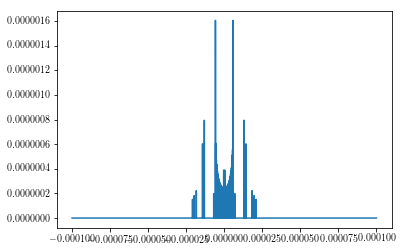

In [202]:
plt.plot(pfrac_array,power_fracs[160])

In [204]:
sig

9.489458348369918e-06

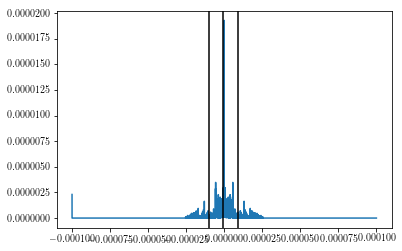

In [203]:
#np.sum(power_fracs,axis=1)
plt.plot(pfrac_array,np.sum(power_fracs,axis=0))
plt.axvline(mean,color="black")
plt.axvline(mean-sig,color="black")
plt.axvline(mean+sig,color="black")

(-9.000900090007629e-09, -1.1001100110009325e-08)

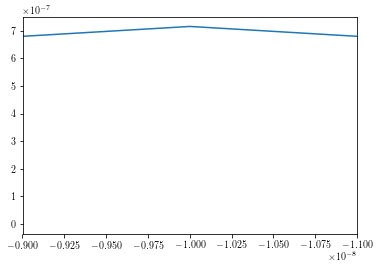

In [156]:
fc = pfrac_array[np.argmax(power_fracs[180])]
plt.plot(pfrac_array,power_fracs[180])
plt.xlim(0.9*fc,1.1*fc)

In [129]:
2*np.pi/10.0*10/(3e5)

2.0943951023931954e-05

In [128]:
np.isnan(Band)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [132]:
Band[np.isnan(Band)] = 0.0
np.sum(power*Band)/np.sum(power)

7.246184410294724e-06

In [133]:
(3.8*1e3)/(1.5e9)

2.5333333333333334e-06

In [134]:
1.6*5e-6*1e6

8.000000000000002

In [136]:
1/10**0.2

0.6309573444801932

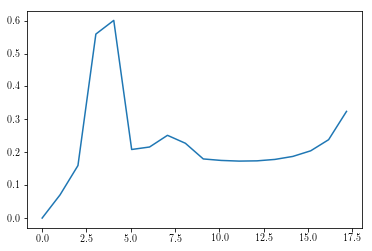

In [92]:
plt.plot(h_array,Band)

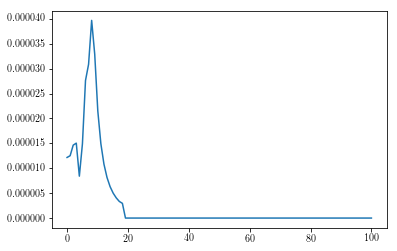

In [87]:
plt.plot(h_array,power)

In [70]:
phi_vec = np.linspace(0,2*np.pi,100)
rs = np.array([find_R(0,phi_vec[i],theta_m=25*np.pi/180.)[0] for i in range(len(phi_vec))])
rcs = np.array([find_R(0,phi_vec[i],theta_m=25*np.pi/180.)[2] for i in range(len(phi_vec))])
Hs = np.array([find_R(0,phi_vec[i],theta_m=25*np.pi/180.)[1] for i in range(len(phi_vec))])

# drdphi = np.zeros(len(rs)-2)
# for i in range(1,len(drdphi)):
#     drdphi[i] = (rs[i+1]-rs[i-1])/(phi_vec[i+1]-phi_vec[i-1])
drdphi = np.gradient(rs)/(phi_vec[1]-phi_vec[0])
    
cos_alpha = drdphi/np.sqrt(drdphi**2+rs**2)

In [72]:
rs

array([14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20602278,
       14.20602278, 14.20602278, 14.20602278, 14.20602278, 14.20

(-1, 1)

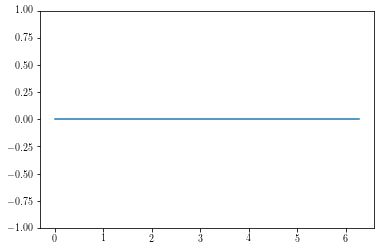

In [79]:
plt.plot(phi_vec,cos_alpha)
plt.ylim(-1,1)

#plt.show()

#plt.plot(phi_vec,rcs)

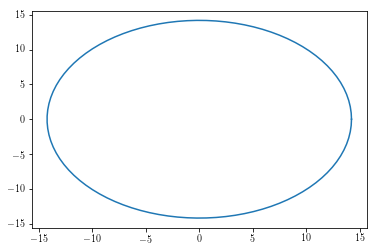

In [74]:
plt.plot(rs*np.cos(phi_vec),rs*np.sin(phi_vec))

In [10]:
rc(np.pi/4.,3,0)

0.5000000000000002